In [48]:
%matplotlib inline

In [49]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
import pickle 



In [51]:
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [52]:
import random 
np.random.seed(0)

In [53]:
#!python3 - m pip install --quiet 

References: https://www.youtube.com/watch?v=j-3vuBynnOE

In [54]:
pwd

'/Users/lenakl/Documents/MIDS/Courses/Fall 2020 Courses/Big Data/BIOS823-Statistical_Programming-for-Big-Data/Homework/Insect_classification'

In [55]:
TRAIN_DIR = '/Users/lenakl/Documents/MIDS/Courses/Fall 2020 Courses/Big Data/BIOS823-Statistical_Programming-for-Big-Data/Homework/Insect_classification/Data_insects/train'
TEST_DIR = '/Users/lenakl/Documents/MIDS/Courses/Fall 2020 Courses/Big Data/BIOS823-Statistical_Programming-for-Big-Data/Homework/Insect_classification/Data_insects/test'
CLASSES = ['beetles', 'cockroach', 'dragonflies']

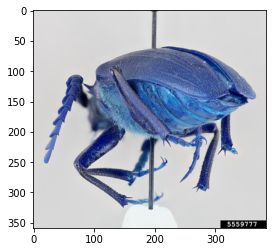

In [56]:
for cl in CLASSES: 
    path = os.path.join(TRAIN_DIR, cl) #path to train data 
    for img in os.listdir(path): 
        img_data = cv2.imread(os.path.join(path, img))
        plt.imshow(img_data)
        break
    break
        

In [57]:
img_data[0].shape

(384, 3)

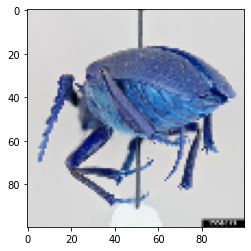

In [58]:
IMG_SIZE = 100
new_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_data)
pass

In [59]:
train_data = []
def create_train_data():
    for cl in CLASSES: 
        path = os.path.join(TRAIN_DIR, cl) #path to train data 
        for img in os.listdir(path): 
            cl_label = CLASSES.index(cl)
            img_data = cv2.imread(os.path.join(path, img))
            IMG_SIZE = 100
            new_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
            train_data.append([new_data, cl_label])
create_train_data()

In [60]:
print(f'{len(train_data)}')

1019


In [61]:
#shuffle the data 
random.shuffle(train_data)

In [62]:
# for obs in train_data[:5]:
#     print(obs[0][0])

In [63]:
test_data = []
def create_test_data():
    for cl in CLASSES: 
        path = os.path.join(TEST_DIR, cl) #path to train data 
        for img in os.listdir(path): 
            cl_label = CLASSES.index(cl)
            img_data = cv2.imread(os.path.join(path, img))
            IMG_SIZE = 100
            new_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_data, cl_label])
create_test_data()

In [64]:
X_train = []
y_train = []
X_test = []
y_test = []

In [65]:
for feature, lb in train_data:
    X_train.append(feature)
    y_train.append(lb)
    
for feature, lb in test_data:
    X_test.append(feature)
    y_test.append(lb)

In [66]:
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
#reshape(-1, IMG_SIZE, IMG_SIZE, 3), where -1 stands for all the observations, 

In [67]:
X_train.shape

(1019, 100, 100, 3)

In [68]:

pickle_out = open('X_train.pickle', 'wb')
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open('y_train.pickle', 'wb')
pickle.dump(y_train, pickle_out)
pickle_out.close()



In [69]:
pickle_in = open('X_train.pickle', 'rb')
X_train = pickle.load(pickle_in)

In [70]:
X_train.shape

(1019, 100, 100, 3)

In [71]:
y_train[:3]

[0, 2, 0]

# MODELING: SIMPLE CNN 

In [72]:
X_train = pickle.load(open('X_train.pickle', 'rb'))
y_train = pickle.load(open('y_train.pickle', 'rb'))

In [ ]:
X_train = X_train/225.0
model = tf.keras.Sequential()
model.add(Conv2D(64, (3,3), input_shape = X_train.shape[1:])) #(3,3) window
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3))) #(3,3) window
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(3))
model.add(Activation('softmax'))
          
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist = model.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.1, verbose = 0)

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(hist.history[measure], label=measure)
    ax.plot(hist.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

In [74]:
#!python3 -m pip install tensorflow==2.0.0-beta1

# Transfer Learning: InceptionV3

In [75]:
# X_trainp = tf.keras.applications.inception_v3.preprocess_input(
#     X_train, data_format=None
# )

In [76]:
# shape = [item[0].shape for item in X_trainp.take(1)][0]
# shape

In [104]:
base_model = InceptionV3(
    input_shape=X_train.shape[1:],
    weights='imagenet', 
    include_top=False,
    classes=3
)

In [105]:
for layer in base_model.layers[:-1]:
    layer.trainable = False

In [106]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [107]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [108]:
model.fit(X_trainp, y_train, batch_size = 32, epochs = 10, validation_split = 0.1)

Train on 917 samples, validate on 102 samples
Epoch 1/10
917/917 [==============================] - 11s 12ms/sample - loss: 1.3321 - accuracy: 0.3697 - val_loss: 1.1495 - val_accuracy: 0.2745
Epoch 2/10
917/917 [==============================] - 4s 5ms/sample - loss: 1.0671 - accuracy: 0.4580 - val_loss: 1.0938 - val_accuracy: 0.4020
Epoch 3/10
917/917 [==============================] - 4s 5ms/sample - loss: 1.0460 - accuracy: 0.4853 - val_loss: 1.1469 - val_accuracy: 0.4118
Epoch 4/10
917/917 [==============================] - 8s 8ms/sample - loss: 1.0149 - accuracy: 0.4885 - val_loss: 1.2888 - val_accuracy: 0.2647
Epoch 5/10
917/917 [==============================] - 7s 8ms/sample - loss: 1.0254 - accuracy: 0.4929 - val_loss: 1.4124 - val_accuracy: 0.2353
Epoch 6/10
917/917 [==============================] - 4s 5ms/sample - loss: 0.9962 - accuracy: 0.4973 - val_loss: 1.3559 - val_accuracy: 0.1863
Epoch 7/10
917/917 [==============================] - 4s 5ms/sample - loss: 1.0302 - acc

In [102]:
#model.summary()

In [103]:
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

180/180 [==============================] - 2s 12ms/sample - loss: 10.3099 - accuracy: 0.3222


0.32222223